# Test the pipeline with the Hungarian Kalman Filter (WKF).

In [1]:
import os
import numpy as np
import torch
import cv2
from torch.utils.data import DataLoader
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

# Get the path of the project root
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))

# Add the project root to sys.path if it is not already in sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Import the ImageSequenceDataset and create_dataloader from the pipeline module
from seismogram_extraction.pipeline import evaluate_filter, create_dataloader
from seismogram_extraction.filters.hungarian_kalman_filter import HungarianKalmanFilter

import torch.multiprocessing as mp
mp.set_start_method('spawn')  # or 'forkserver' if available

from collections import defaultdict


# Overlap: 0

In [2]:
### Parameters
Dts = [0.06, 0.08, 0.09]
qs = [0.5, 1.0, 1.5]
sigma_zs = [0.05, 0.1, 0.15]

sources = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-00",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-0"]

# Initialize result structure
results_table = defaultdict(lambda: defaultdict(dict))

if __name__ == "__main__":
    # Grid search loop
    min_RMSE = np.inf
    best_params = {}
    best_result = None

    for Dt in tqdm(Dts, desc='Dt'):
        for sigma_z in sigma_zs:
            for q in qs:
                rmse_list = []
                for source in sources:

                    A = np.array([[1, Dt, Dt**2/2, Dt**3/6],
                                [0, 1, Dt, Dt**2/2],
                                [0, 0, 1, Dt],
                                [0, 0, 0, 1]]).astype(np.float64)
                                                        
                    H = np.array([[1, 0, 0, 0]]).astype(np.float64)

                    Dt2 = Dt ** 2
                    Dt3 = Dt ** 3
                    Dt4 = Dt ** 4
                    Dt5 = Dt ** 5
                    Dt6 = Dt ** 6
                    Dt7 = Dt ** 7

                    Q = q * np.array([
                        [Dt7/252, Dt6/72,  Dt5/30, Dt4/24],
                        [Dt6/72,  Dt5/20,  Dt4/8,  Dt3/6 ],
                        [Dt5/30,  Dt4/8,   Dt3/3,  Dt2/2 ],
                        [Dt4/24,  Dt3/6,   Dt2/2,  Dt    ]
                    ])

                    R = np.array([[sigma_z**2]])

                    # Initial state covariance given all_x_0
                    P = np.zeros((4, 4))
                    P[1, 1] = 10
                    P[2, 2] = 10
                    P[3, 3] = 10

                    image_folder_path = source + r"\signals"
                    GTs_folder_path = source + r"\ground_truth"
                    output_folder_path = None # don't save

                    RMSE_new, _ = evaluate_filter(
                        image_folder_path, GTs_folder_path, output_folder_path,
                        HungarianKalmanFilter(A, H, Q, R),
                        batch_size=25, step=1, save=False
                    )
                    rmse_list.append(RMSE_new)

                RMSE = np.mean(rmse_list)
                RMSE_std = np.std(rmse_list)
                results_table[Dt][q][sigma_z] = (RMSE, RMSE_std)

                if RMSE < min_RMSE:
                    min_RMSE = RMSE
                    min_RMSE_std = RMSE_std
                    best_params = {'Dt': Dt, 'q' : q, 'sigma_z': sigma_z}

                    print('Best parameters:', best_params)
                    print('Minimum RMSE:', min_RMSE)
                    print('Minimum RMSE std:', min_RMSE_std)
                            
    print('Best parameters:', best_params)
    print('Minimum RMSE:', min_RMSE)
    print('Minimum RMSE std:', min_RMSE_std)

Dt:   0%|          | 0/3 [00:00<?, ?it/s]

Best parameters: {'Dt': 0.06, 'q': 0.5, 'sigma_z': 0.05}
Minimum RMSE: 43.88088878895404
Minimum RMSE std: 40.47211505920714
Best parameters: {'Dt': 0.06, 'q': 1.0, 'sigma_z': 0.05}
Minimum RMSE: 9.077824214346913
Minimum RMSE std: 6.133599944214681


Dt: 100%|██████████| 3/3 [14:07<00:00, 282.35s/it]

Best parameters: {'Dt': 0.06, 'q': 1.0, 'sigma_z': 0.05}
Minimum RMSE: 9.077824214346913
Minimum RMSE std: 6.133599944214681


In [3]:
output_dir = os.path.join("output", "HKF_degree4", "overlap_0")
os.makedirs(output_dir, exist_ok=True)  

for Dt in Dts:
    latex = []
    latex.append(r"\begin{table}[H]")
    latex.append(r"\centering")
    latex.append(r"\begin{tabular}{c|" + "c" * len(sigma_zs) + "}")
    latex.append(r"$q \backslash \sigma_z$ & " + " & ".join([f"{sigma:.2f}" for sigma in sigma_zs]) + r"\\")
    latex.append(r"\hline")

    for q in qs:
        row = [f"{q:.2f}"]
        for sigma_z in sigma_zs:
            rmse_tuple = results_table[Dt][q].get(sigma_z, None)
            if rmse_tuple is not None:
                rmse, std = rmse_tuple
                row.append(f"{rmse:.3f} | {std:.3f}")
            else:
                row.append("-")
        latex.append(" & ".join(row) + r"\\")

    latex.append(r"\end{tabular}")
    latex.append(rf"\caption{{RMSE for Dt = {Dt:.2f}}}")
    latex.append(rf"\label{{tab:rmse_dt_{str(Dt).replace('.', '_')}}}")
    latex.append(r"\end{table}")
    latex.append("")

    # Write to file
    file_path = os.path.join(output_dir, f"RMSE_table_dt_{str(Dt).replace('.', '_')}.tex")
    with open(file_path, "w") as f:
        f.write("\n".join(latex))

print("LaTeX tables written.")


LaTeX tables written.


Final evaluation using best parameters:
RMSE: 14.887512663190773
RMSE std: 12.824539757106518


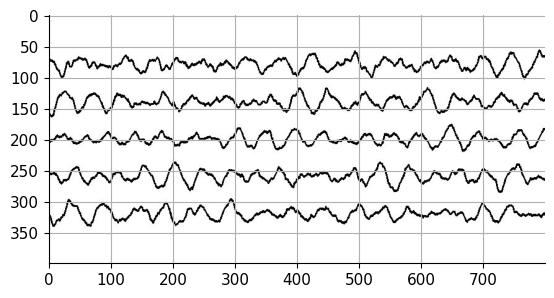

In [4]:
sources = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-00",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-0"]

if __name__ == "__main__":
    Dt = best_params['Dt']
    q = best_params['q']
    sigma_z = best_params['sigma_z']

    rmse_list = []
    for source in sources:
        A = np.array([[1, Dt, Dt**2/2],
                                [0, 1, Dt], 
                                [0, 0, 1]]).astype(np.float64)
                                                        
        H = np.array([[1, 0, 0]]).astype(np.float64)

        Q = q * np.array([[Dt**5/20, Dt**4/8, Dt**3/6],
                                    [Dt**4/8, Dt**3/3, Dt**2/2],
                                    [Dt**3/6, Dt**2/2, Dt]])

        R = np.array([[sigma_z**2]])

        # Initial state covariance given all_x_0
        P = np.zeros((3, 3))
        P[1, 1] = 10
        P[2, 2] = 10

        image_folder_path = os.path.join(source, "signals")
        GTs_folder_path = os.path.join(source, "ground_truth")

        output_folder_path = os.path.join(source, "processed_HKF_4_dt{:.2f}_q{:.2f}_sigma_z{:.2f}".format(Dt, q, sigma_z))
        os.makedirs(output_folder_path, exist_ok=True)

        # Evaluate on this source (returns RMSE for the image set)
        RMSE_new, _ = evaluate_filter(
            image_folder_path,
            GTs_folder_path,
            output_folder_path,
            HungarianKalmanFilter(A, H, Q, R),
            batch_size=25,
            step=1
        )
        rmse_list.append(RMSE_new)

    # Compute global statistics
    RMSE = np.mean(rmse_list)
    RMSE_std = np.std(rmse_list)

    print('Final evaluation using best parameters:')
    print('RMSE:', RMSE)
    print('RMSE std:', RMSE_std)

Dt:   0%|          | 0/5 [00:00<?, ?it/s]
Best parameters: {'Dt': 0.01, 'q': 1e-05, 'sigma_z': 0.1}
Minimum MSE: 208.98985589453468
Minimum MSE std: 0.0
Best parameters: {'Dt': 0.01, 'q': 0.001, 'sigma_z': 0.1}
Minimum MSE: 172.70384832526176
Minimum MSE std: 0.0
Best parameters: {'Dt': 0.01, 'q': 1.0, 'sigma_z': 0.1}
Minimum MSE: 112.65773816886501
Minimum MSE std: 0.0
Best parameters: {'Dt': 0.01, 'q': 0.1, 'sigma_z': 4.0}
Minimum MSE: 97.76159883749374
Minimum MSE std: 0.0
Dt:  60%|██████    | 3/5 [58:52<39:20, 1180.01s/it]  
Best parameters: {'Dt': 0.1, 'q': 1.0, 'sigma_z': 2.0}
Minimum MSE: 77.08767803310535
Minimum MSE std: 0.0
Dt: 100%|██████████| 5/5 [1:38:31<00:00, 1182.33s/it]
Best parameters: {'Dt': 0.1, 'q': 1.0, 'sigma_z': 2.0}
Minimum MSE: 77.08767803310535
Minimum MSE std: 0.0

# Medium Overlap

In [2]:
### Parameters 
Dts = [0.05, 0.15, 0.1, 1]
qs = [0.01, 0.1, 1]
sigma_zs = [0.01, 0.1, 1]

sources = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-28"]
# r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-38"]

# Initialize result structure
results_table = defaultdict(lambda: defaultdict(dict))

if __name__ == "__main__":
    # Grid search loop
    min_RMSE = np.inf
    best_params = {}
    best_result = None

    for Dt in tqdm(Dts, desc='Dt'):
        for sigma_z in sigma_zs:
            for q in qs:
                rmse_list = []
                for source in sources:

                    A = np.array([[1, Dt, Dt**2/2, Dt**3/6],
                                [0, 1, Dt, Dt**2/2],
                                [0, 0, 1, Dt],
                                [0, 0, 0, 1]]).astype(np.float64)
                                                        
                    H = np.array([[1, 0, 0, 0]]).astype(np.float64)

                    Dt2 = Dt ** 2
                    Dt3 = Dt ** 3
                    Dt4 = Dt ** 4
                    Dt5 = Dt ** 5
                    Dt6 = Dt ** 6
                    Dt7 = Dt ** 7

                    Q = q * np.array([
                        [Dt7/252, Dt6/72,  Dt5/30, Dt4/24],
                        [Dt6/72,  Dt5/20,  Dt4/8,  Dt3/6 ],
                        [Dt5/30,  Dt4/8,   Dt3/3,  Dt2/2 ],
                        [Dt4/24,  Dt3/6,   Dt2/2,  Dt    ]
                    ])

                    R = np.array([[sigma_z**2]])

                    # Initial state covariance given all_x_0
                    P = np.zeros((4, 4))
                    P[1, 1] = 10
                    P[2, 2] = 10
                    P[3, 3] = 10

                    image_folder_path = source + r"\signals"
                    GTs_folder_path = source + r"\ground_truth"
                    output_folder_path = None # don't save

                    RMSE_new, _ = evaluate_filter(
                        image_folder_path, GTs_folder_path, output_folder_path,
                        HungarianKalmanFilter(A, H, Q, R),
                        batch_size=25, step=1, save=False
                    )
                    rmse_list.append(RMSE_new)

                RMSE = np.mean(rmse_list)
                RMSE_std = np.std(rmse_list)
                results_table[Dt][q][sigma_z] = (RMSE, RMSE_std)

                if RMSE < min_RMSE:
                    min_RMSE = RMSE
                    min_RMSE_std = RMSE_std
                    best_params = {'Dt': Dt, 'q' : q, 'sigma_z': sigma_z}

                    print('Best parameters:', best_params)
                    print('Minimum RMSE:', min_RMSE)
                    print('Minimum RMSE std:', min_RMSE_std)
                            
    print('Best parameters:', best_params)
    print('Minimum RMSE:', min_RMSE)
    print('Minimum RMSE std:', min_RMSE_std)

Dt:   0%|          | 0/4 [00:00<?, ?it/s]

Best parameters: {'Dt': 0.05, 'q': 0.01, 'sigma_z': 0.01}
Minimum RMSE: 13135.654540013813
Minimum RMSE std: 0.0
Best parameters: {'Dt': 0.05, 'q': 0.1, 'sigma_z': 0.01}
Minimum RMSE: 4614.528808430716
Minimum RMSE std: 0.0


Dt:  50%|█████     | 2/4 [05:15<05:14, 157.20s/it]

Best parameters: {'Dt': 0.1, 'q': 0.01, 'sigma_z': 0.1}
Minimum RMSE: 2568.1450887716082
Minimum RMSE std: 0.0


Dt:  75%|███████▌  | 3/4 [07:47<02:34, 154.81s/it]

Best parameters: {'Dt': 0.1, 'q': 1, 'sigma_z': 1}
Minimum RMSE: 219.61315585464226
Minimum RMSE std: 0.0


Dt: 100%|██████████| 4/4 [10:03<00:00, 150.75s/it]

Best parameters: {'Dt': 0.1, 'q': 1, 'sigma_z': 1}
Minimum RMSE: 219.61315585464226
Minimum RMSE std: 0.0


In [6]:
output_dir = os.path.join("output", "HKF_4", "overlap_28")
os.makedirs(output_dir, exist_ok=True)  

for Dt in Dts:
    latex = []
    latex.append(r"\begin{table}[H]")
    latex.append(r"\centering")
    latex.append(r"\begin{tabular}{c|" + "c" * len(sigma_zs) + "}")
    latex.append(r"$q \backslash \sigma_z$ & " + " & ".join([f"{sigma:.2f}" for sigma in sigma_zs]) + r"\\")
    latex.append(r"\hline")

    for q in qs:
        row = [f"{q:.2f}"]
        for sigma_z in sigma_zs:
            rmse_tuple = results_table[Dt][q].get(sigma_z, None)
            if rmse_tuple is not None:
                rmse, std = rmse_tuple
                row.append(f"{rmse:.3f} | {std:.3f}")
            else:
                row.append("-")
        latex.append(" & ".join(row) + r"\\")

    latex.append(r"\end{tabular}")
    latex.append(rf"\caption{{RMSE for Dt = {Dt:.2f}}}")
    latex.append(rf"\label{{tab:rmse_dt_{str(Dt).replace('.', '_')}}}")
    latex.append(r"\end{table}")
    latex.append("")

    # Write to file
    file_path = os.path.join(output_dir, f"RMSE_table_dt_{str(Dt).replace('.', '_')}.tex")
    with open(file_path, "w") as f:
        f.write("\n".join(latex))

print("LaTeX tables written.")

LaTeX tables written.


Final evaluation using best parameters:
RMSE: 69892.44848360379
RMSE std: 67876.29667073516


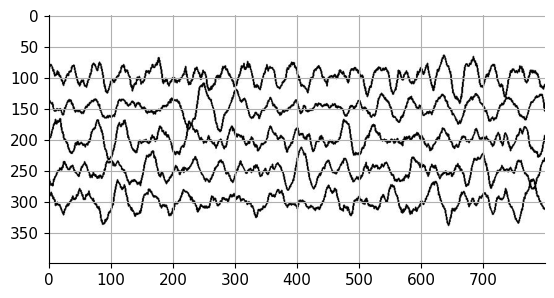

In [7]:
sources = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-28",
           r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\resampled\BE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1\overlap_0-38"]
        #    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-06",
        #    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-11",
        #    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-17",
        #    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-22",
        #    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-28",
        #    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-33",
        #    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-39",
        #    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-44",
        #    r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\sines_long\overlap_0-50"]

if __name__ == "__main__":
    Dt = best_params['Dt']
    q = best_params['q']
    sigma_z = best_params['sigma_z']

    rmse_list = []
    for source in sources:
        A = np.array([[1, Dt, Dt**2/2, Dt**3/6],
                                [0, 1, Dt, Dt**2/2],
                                [0, 0, 1, Dt],
                                [0, 0, 0, 1]]).astype(np.float64)
                                                        
        H = np.array([[1, 0, 0, 0]]).astype(np.float64)
        Dt2 = Dt ** 2
        Dt3 = Dt ** 3
        Dt4 = Dt ** 4
        Dt5 = Dt ** 5
        Dt6 = Dt ** 6
        Dt7 = Dt ** 7

        Q = q * np.array([
                        [Dt7/252, Dt6/72,  Dt5/30, Dt4/24],
                        [Dt6/72,  Dt5/20,  Dt4/8,  Dt3/6 ],
                        [Dt5/30,  Dt4/8,   Dt3/3,  Dt2/2 ],
                        [Dt4/24,  Dt3/6,   Dt2/2,  Dt    ]
                    ])

        R = np.array([[sigma_z**2]])

        # Initial state covariance given all_x_0
        P = np.zeros((4, 4))
        P[1, 1] = 10
        P[2, 2] = 10
        P[3, 3] = 10

        image_folder_path = os.path.join(source, "signals")
        GTs_folder_path = os.path.join(source, "ground_truth")

        output_folder_path = os.path.join(source, "processed_HKF_4_dt{:.2f}_q{:.2f}_sigma_z{:.2f}".format(Dt, q, sigma_z))
        os.makedirs(output_folder_path, exist_ok=True)

        # Evaluate on this source (returns RMSE for the image set)
        RMSE_new, _ = evaluate_filter(
            image_folder_path,
            GTs_folder_path,
            output_folder_path,
            HungarianKalmanFilter(A, H, Q, R),
            batch_size=25,
            step=1
        )
        rmse_list.append(RMSE_new)

    # Compute global statistics
    RMSE = np.mean(rmse_list)
    RMSE_std = np.std(rmse_list)

    print('Final evaluation using best parameters:')
    print('RMSE:', RMSE)
    print('RMSE std:', RMSE_std)

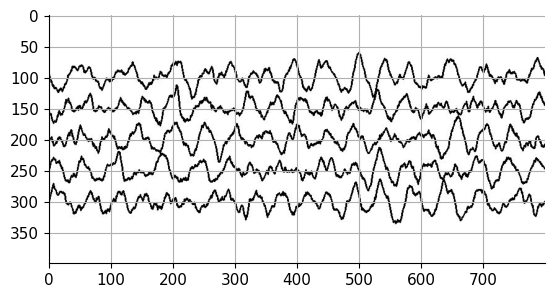

In [ ]:
# Evaluate with true seismogram data
image_folder_path = [r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\seismograms"]

if __name__ == "__main__":
    Dt = best_params['Dt']
    q = best_params['q']
    sigma_z = best_params['sigma_z']

    A = np.array([[1, Dt, Dt**2/2],
                  [0, 1, Dt], 
                  [0, 0, 1]]).astype(np.float64)
                                                        
    H = np.array([[1, 0, 0]]).astype(np.float64)

    Q = q * np.array([[Dt**5/20, Dt**4/8, Dt**3/6],
                                    [Dt**4/8, Dt**3/3, Dt**2/2],
                                    [Dt**3/6, Dt**2/2, Dt]])

    R = np.array([[sigma_z**2]])

    # Initial state covariance given all_x_0
    P = np.zeros((3, 3))
    P[1, 1] = 10
    P[2, 2] = 10

    image_folder_path = os.path.join(source, "signals")

    output_folder_path = os.path.join(source, "processed_HKF_dt{:.2f}_q{:.2f}_sigma_z{:.2f}".format(Dt, q, sigma_z))
    os.makedirs(output_folder_path, exist_ok=True)

    # Evaluate on this source (returns RMSE for the image set)
    _, _ = evaluate_filter(
            image_folder_path,
            GTs_folder_path,
            output_folder_path,
            HungarianKalmanFilter(A, H, Q, R),
            batch_size=25,
            step=1
        )